# Epymix integration

This tutorial demonstrate how an existing openalea model (epymix) can be exported as an IPM-compliant web service

## Get Epymix factory from OpenAlea package manager

In [1]:
from openalea.core.pkgmanager import PackageManager
pm = PackageManager()
pm.init()

In [2]:
factory = pm['ipmdecisions.epymix']['epymix_seir']
node = factory.instantiate()

In [3]:
[v['name'] for v in node.input_desc], node.output_desc

(['sowing_date',
  'daily_tmin',
  'daily_tmax',
  'daily_rain',
  'delta_t',
  'rainfall_threshold',
  'scenario_ino',
  'Lx',
  'Ly',
  'Lr',
  'frac_inf',
  'inoc_init_abs',
  'ng_ext0_abs',
  'scenario_rot',
  'wheat_fraction',
  'day_length',
  'alpha_ure',
  'radius_ure',
  'alpha_asco',
  'radius_asco',
  'alpha_pycnid',
  'radius_pycnid',
  't',
  'season',
  'mu_companion',
  'beta_companion',
  'end_companion',
  'LAI_K',
  'delta_companion',
  'disease',
  'mu_wheat',
  'nu',
  'beta_wheat',
  'end_wheat',
  'ber_wheat',
  'ber_companion',
  'h_wheat',
  'h_companion',
  'lambd',
  'delta_ei',
  's0',
  'pi_inf0',
  'rho',
  'psi',
  'gamma',
  'theta',
  'sigma',
  'sigma_asco',
  'inf_begin'],
 [{'name': 'Nsp', 'interface': 'ISequence'},
  {'name': 'Pth', 'interface': 'ISequence'},
  {'name': 'Poi', 'interface': 'ISequence'},
  {'name': 'Sth', 'interface': 'ISequence'},
  {'name': 'Sus', 'interface': 'ISequence'},
  {'name': 'Lat', 'interface': 'ISequence'},
  {'name': 'If

In [4]:
factory.get_id(), factory.get_authors()

('epymix_SEIR',
 'Sebastien Levionnois, Christophe Pradal, ... (wralea authors)')

In [5]:
factory.get_node_file().replace('\\','/')

'c:/users/fourniec/develop/ipm/epymix/src/epymix/wralea/adaptor.py'

## Create IPM model

In [6]:
from openalea.dss.dss_factory import dss_factory
help(dss_factory)

Help on function dss_factory in module openalea.dss.dss_factory:

dss_factory(model_id, node, factory=None, interval=86400, weather_parameters=None, config_params=None, decision_support=None, meta=None)
    Transform an openalea node in a IPM model json descriptor and generate a fastAPI script to launch webservice
    
    Args:
        node: the node to be exported
        factory
    
        : the node factory associated to the node (optional)
        interval: the time step of the model (s)
        weather_parameters: a mapping between node input name and weather data codes, if any.
        None if none of the input is a weather data
        parameters: a list of node input name to be exposed as config parameters in IPM-Decison platform
        meta : model meta informations
    Returns:
        model: a json-like dict describing the model
        dss_service: a string containing the script to be run for launching the web service



In [7]:
input_mapping = {'weather_parameters': {"daily_tmin": 1003, "daily_tmax": 1004, "daily_rain": 2001},
                 'config_params': ["sowing_date", "delta_t", "rainfall_threshold", "scenario_ino", "Lx", "Ly", "Lr", "frac_inf", "inoc_init_abs", "ng_ext0_abs", "scenario_rot", "wheat_fraction"]}
ipm_model, service = dss_factory('epymix', node, factory=factory,**input_mapping)

In [8]:
ipm_model

{'id': 'epymix',
 'name': 'Sample model',
 'version': '0.0.0',
 'purpose': 'Sample meta informations generated by openalea dss facctory',
 'description': 'Please provide here a concise description of the model',
 'type_of_decision': 'Short-term tactical',
 'type_of_output': 'Risk indication',
 'description_url': None,
 'citation': None,
 'keywords': None,
 'platform_validated': False,
 'pests': [],
 'crops': [],
 'authors': [{'name': 'Anonymous',
   'email': 'anonymous@mail',
   'organization': 'Unknown'}],
 'valid_spatial': {'countries': [], 'geoJSON': '{}'},
 'execution': {'type': 'ONTHEFLY',
  'endpoint': 'http://127.0.0.1:8000/epymix/',
  'form_method': 'post',
  'content_type': 'application/json',
  'input_schema_categories': {'hidden': ['modelId'],
   'system': [],
   'user_init': [],
   'triggered': [],
   'internal': []},
  'input_schema': {'type': 'object',
   'properties': {'configParameters': {'title': 'Configuration parameters',
     'type': 'object',
     'properties': {'t

In [9]:
print(service)

from __future__ import annotations

from typing import List

from pydantic import BaseModel


class ConfigParameters(BaseModel):
    timeZone: str
    timeStart: str
    timeEnd: str
    sowing_date: str
    delta_t: int
    rainfall_threshold: int
    scenario_ino: str
    Lx: int
    Ly: int
    Lr: int
    frac_inf: int
    inoc_init_abs: int
    ng_ext0_abs: int
    scenario_rot: str
    wheat_fraction: float


class LocationWeatherDatum(BaseModel):
    longitude: float
    latitude: float
    altitude: float
    data: List[List[float]]
    length: int
    width: int


class WeatherData(BaseModel):
    timeStart: str
    timeEnd: str
    interval: int
    weatherParameters: List[int]
    locationWeatherData: List[LocationWeatherDatum]


class PydanticModel(BaseModel):
    modelId: str
    configParameters: ConfigParameters
    weatherData: WeatherData


from fastapi import FastAPI
from openalea.dss.dss_factory import encode_input, encode_output

app = FastAPI()

from openalea.core.

## Launch the Webservice

In [10]:
from openalea.dss.dss_factory import start_service, stop_service

http, handler = start_service(service)

In [11]:
from IPython.display import IFrame

In [12]:
IFrame(http + '/docs', 800,400)

## Test the exported model

In [13]:
import agroservices.ipm.fakers as ipm_fakers
from agroservices.ipm.ipm import IPM

In [14]:
ipm = IPM()
input_data = ipm_fakers.input_data(ipm_model)
input_data

{'configParameters': {'timeZone': 'Europe/Oslo',
  'timeStart': '2023-03-01',
  'timeEnd': '2023-09-01',
  'sowing_date': '2019-09-01',
  'delta_t': 10,
  'rainfall_threshold': 3,
  'scenario_ino': 'initial_inoculum',
  'Lx': 1,
  'Ly': 1,
  'Lr': 1,
  'frac_inf': 1,
  'inoc_init_abs': 20000000,
  'ng_ext0_abs': 20000,
  'scenario_rot': 'uniform',
  'wheat_fraction': 0.5},
 'modelId': 'epymix',
 'weatherData': {'weatherParameters': [1003, 1004, 2001],
  'timeStart': '2023-03-01T00:00:00+01:00',
  'timeEnd': '2023-09-01T00:00:00+02:00',
  'interval': 86400,
  'locationWeatherData': [{'longitude': 154.74998601190666,
    'latitude': 43.37446720657104,
    'altitude': 0,
    'data': [[3.6, 4.9, 8.6],
     [8.4, 9.8, 7.3],
     [2.0, 1.7, 4.0],
     [6.9, 7.1, 4.4],
     [2.0, 4.5, 7.2],
     [6.3, 3.5, 8.4],
     [9.5, 9.0, 1.0],
     [4.1, 4.0, 2.4],
     [7.3, 5.2, 3.3],
     [7.8, 4.5, 9.4],
     [1.7, 6.6, 7.0],
     [6.1, 0.2, 3.2],
     [3.4, 6.3, 7.6],
     [9.7, 9.1, 2.2],
     [9

In [15]:
output = ipm.run_model(ipm_model, input_data)
output

{'timeStart': '2023-03-01T00:00:00+01:00',
 'timeEnd': '2023-09-01T00:00:00+02:00',
 'interval': 86400,
 'resultParameters': ['Nsp',
  'Pth',
  'Poi',
  'Sth',
  'Sus',
  'Lat',
  'Ifc',
  'Ifv',
  'Rem',
  'LAI',
  'LAI_wheat',
  'Poo',
  'Eps',
  'AUDPC',
  'Scont'],
 'locationResult': [{'longitude': 154.74998601190666,
   'latitude': 43.37446720657104,
   'altitude': 0.0,
   'data': [[0.0,
     0.003,
     0.003,
     0.003,
     0.003,
     0.0,
     0.0,
     0.0,
     0.0,
     0.006,
     0.003,
     20000000.0,
     0.005982035946064687,
     0.0,
     0.0],
    [19714285.714285716,
     0.00326973,
     0.00326973,
     0.00326973,
     0.002294603175785108,
     0.0009751268242148925,
     0.0,
     0.0,
     0.0,
     0.00653946,
     0.00326973,
     19959976.41368684,
     0.00651812426485021,
     0.0,
     0.0009751268242148925],
    [19409691.373295788,
     0.003563684965971813,
     0.003563684965971813,
     0.003563684965971813,
     0.0018523128363425153,
     0.00

In [16]:
import pandas
df = pandas.DataFrame(dict(zip(output['resultParameters'],zip(*output['locationResult'][0]['data']))))
df

,Nsp,Pth,Poi,Sth,Sus,Lat,Ifc,Ifv,Rem,LAI,LAI_wheat,Poo,Eps,AUDPC,Scont
0,0.000000e+00,0.003000,0.003000,0.003000,0.003000,0.000000,0.000000,0.000000,0.000000,0.006000,0.003000,2.000000e+07,0.005982,0.000000,0.000000
1,1.971429e+07,0.003270,0.003270,0.003270,0.002295,0.000975,0.000000,0.000000,0.000000,0.006539,0.003270,1.995998e+07,0.006518,0.000000,0.000975
2,1.940969e+07,0.003564,0.003564,0.003564,0.001852,0.001711,0.000000,0.000000,0.000000,0.007127,0.003564,1.994003e+07,0.007102,0.000000,0.000736
3,1.908546e+07,0.003884,0.003884,0.003884,0.001587,0.002297,0.000000,0.000000,0.000000,0.007768,0.003884,1.990012e+07,0.007738,0.000000,0.000586
4,1.878297e+07,0.004233,0.004233,0.004233,0.001440,0.002793,0.000000,0.000000,0.000000,0.008466,0.004233,1.988029e+07,0.008431,0.000000,0.000495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,0.000000e+00,2.988344,0.118368,0.118368,0.048518,0.003996,0.046348,0.924488,2.893032,5.980238,2.991894,1.173762e+08,0.195255,122.476516,0.000000
246,4.171314e+05,2.988344,0.114817,0.114817,0.046700,0.003967,0.045232,0.924763,2.895997,5.980240,2.991896,1.175586e+08,0.189996,123.401279,0.000363
247,0.000000e+00,2.988344,0.111372,0.111372,0.045299,0.003590,0.044125,0.925012,2.898863,5.980220,2.991876,1.173235e+08,0.184853,124.326291,0.000000
248,3.971223e+05,2.988344,0.108031,0.108031,0.043616,0.003562,0.043048,0.925260,2.901652,5.980222,2.991878,1.174859e+08,0.179841,125.251551,0.000324


<Axes: >

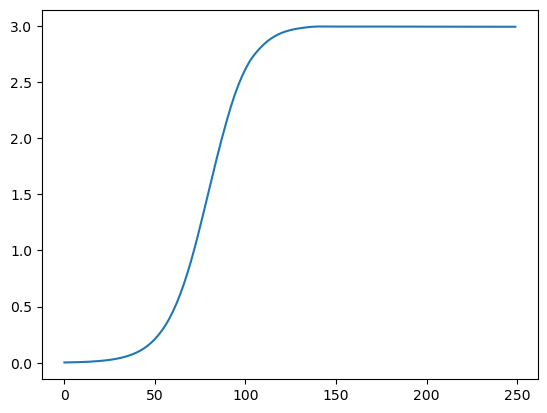

In [17]:
df.loc[:,'LAI_wheat'].plot()

# Stop service

In [ ]:
stop_service(handler)

In [18]:
IFrame(http + '/docs', 800,400)